In [70]:
import argparse

import cv2 as cv
import numpy as np
import glob

from trainer.segnet import build_encoder_decoder, build_refinement
from trainer.utils import get_final_output
from trainer.config import channel
import matplotlib.pyplot as plt

from trainer.utils import compute_mse_loss, compute_sad_loss

In [99]:
checkpoint_path = '/Users/erez/Downloads/deep_image_matting_20190515_121805_checkpoints_encoder_decoder.41-0.0093.hdf5'
test_path = '/Users/erez/Desktop/data/bangladesh_test/test_images'
test_mask_path = '/Users/erez/Desktop/data/bangladesh_test/test_masks/JPEG'
stage = 'encoder_decoder'

In [100]:
model = build_encoder_decoder()

if stage == 'refinement':
    model = build_refinement(model)

model.load_weights(checkpoint_path)

In [101]:
files = glob.glob(test_path + "/*.jpg")
num_images = len(files)

img_rows, img_cols = 320, 320

test_images = np.empty((num_images, img_rows, img_cols, channel), dtype=np.float32) 
test_masks = np.empty((num_images,img_rows,img_cols), dtype=np.uint8)

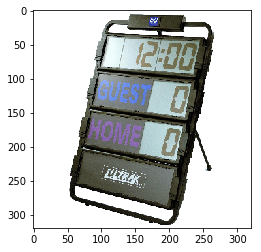

In [106]:
count = 0
for f in os.listdir(test_path): 
    if f.endswith(".jpg"):     
        img = cv.imread(os.path.join(test_path, f))

        mask = cv.imread(os.path.join(test_mask_path, f),0)
        
        
        img = cv.resize(img, (img_rows, img_cols))
        mask = cv.resize(mask, (img_rows, img_cols))
        

        test_masks[count, :, :] = mask
        test_images[count, :, :, 0:3] = img / 255.
        count = count + 1


In [107]:
out = model.predict(test_images)
out = np.reshape(out, (num_images, img_rows, img_cols))
out = out * 255
out = out.astype(np.uint8)

In [108]:
mse_loss = []
sad_loss = []
for i in range(len(out)):
    mse_loss.append(compute_mse_loss(out[i], test_masks[i], np.ones((img_rows, img_cols), dtype=np.uint8)*128))
    sad_loss.append(compute_sad_loss(out[i], test_masks[i], np.ones((img_rows, img_cols), dtype=np.uint8)*128))
    
print("SAD Loss: " + str(np.mean(sad_loss)))
print("MSE Loss: " + str(np.mean(mse_loss)))

SAD Loss: 28105.223137254903
MSE Loss: 0.27061188450656


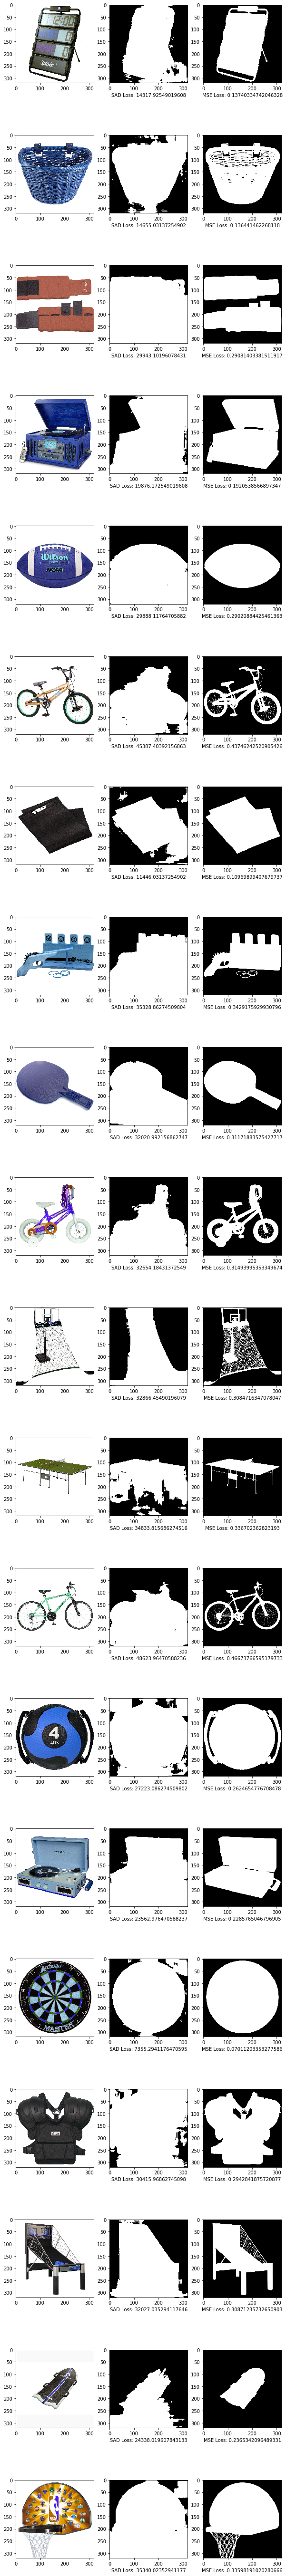

In [109]:
f, ax = plt.subplots(num_images,3, figsize = (10,100))

for i in range(num_images): 
    ax[i,0].imshow(test_images[i])
    ax[i,1].imshow(out[i], cmap = 'gray')
    ax[i,1].set_xlabel("SAD Loss: " + str(sad_loss[i]))
    ax[i,2].imshow(test_masks[i], cmap = 'gray')
    ax[i,2].set_xlabel("MSE Loss: " + str(mse_loss[i]))

